In [1]:
import tensorflow as tf
import numpy as np
import keras
import pandas as pd

from keras.layers import Input, Flatten, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split


from visualizacao import *

class Gerador:
    """
    Dados de entrada: input_shape=(64, 64, 3), min_layers=2, max_layers=6\n
    Caso queira aumentar as camadas, deve aumentar o tamanho do input
    """
    def __init__(self, input_shape=(64, 64, 3), min_layers=2, max_layers=6, nomeModelo:str=None):
        self.input_shape = input_shape
        self.min_layers = min_layers
        self.max_layers = max_layers
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.treino = None
        self.validacao = None
        self.teste = None
        self.nomeModelo = nomeModelo
        self.datagen = ImageDataGenerator(rescale=1./255)  # Add more preprocessing as needed


    def setNome(self, nome):
        self.nomeModelo = nome

    def getPesos(self):
        dir = f"weights_finais/Autoencoders_Gerados/{self.nomeModelo}.weights.h5"
        return str(dir)
    
    def calcular_camadas(self):
        num_layers = np.random.randint(self.min_layers, self.max_layers + 1)
        
        encoder_layers = []
        decoder_layers = []
        
        shape_atual = self.input_shape
        
        # Encoder
        for i in range(num_layers):
            filters = np.random.randint(16, 256)
            encoder_layers.append(Conv2D(filters, (3, 3), activation='relu', padding='same'))
            encoder_layers.append(MaxPooling2D((2, 2), padding='same'))
            shape_atual = (shape_atual[0] // 2, shape_atual[1] // 2, filters) #att por conta da divisão do maxpool
        latent_dim = np.prod(shape_atual)
        encoder_layers.append(Flatten())

        # Decoder
        decoder_layers = [
            Dense(np.prod(shape_atual), activation='relu'),
            Reshape(shape_atual)
        ]
        
        for i in range(num_layers):
            filters = np.random.randint(16, 512)
            decoder_layers.append(Conv2D(filters, (3, 3), activation='relu', padding='same'))
            decoder_layers.append(UpSampling2D((2, 2))) #maxpool ao contrário, aumenta a resolução 
        decoder_layers.append(Conv2D(self.input_shape[2], (3, 3), activation='sigmoid', padding='same'))
        
        return encoder_layers, decoder_layers, latent_dim

    def construir_modelo(self):
        encoder_layers, decoder_layers, latent_dim = self.calcular_camadas()
        
        # Construir encoder
        inputs = Input(shape=self.input_shape)
        x = inputs
        for layer in encoder_layers:
            x = layer(x) #as camadas vão sequencialmente sendo adicionadas 
        self.encoder = Model(inputs, x, name='encoder')
        
        # Construir decoder
        latent_inputs = Input(shape=(latent_dim,))
        x = latent_inputs
        for layer in decoder_layers:
            x = layer(x)
        self.decoder = Model(latent_inputs, x, name='decoder')
        
        # Construir autoencoder
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        self.autoencoder = Model(inputs, decoded, name='autoencoder')

        print(f"Encoder output shape: {self.encoder.output_shape}")
        print(f"Decoder input shape: {self.decoder.input_shape}")
        print(f"Decoder output shape: {self.decoder.output_shape}")
        
        return self.autoencoder

    def compilar_modelo(self, optimizer='adam', loss='mse'):
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    def Dataset(self, caminho_csv):
        dataframe = pd.read_csv(caminho_csv)
        X_train_val, X_test, y_train_val, y_test = train_test_split(dataframe['caminho_imagem'], dataframe['classe'], test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 25% de 80% é 20%

        train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
        val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
        test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

        self.treino = self.datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col='class',
            target_size=self.input_shape[:2],
            batch_size=32,
            class_mode='input'  # 'input' for autoencoder
        )
        self.validacao = self.datagen.flow_from_dataframe(
            val_df,
            x_col='filename',
            y_col='class',
            target_size=self.input_shape[:2],
            batch_size=32,
            class_mode='input'
        )
        self.teste = self.datagen.flow_from_dataframe(
            test_df,
            x_col='filename',
            y_col='class',
            target_size=self.input_shape[:2],
            batch_size=32,
            class_mode='input'
        )

    def treinar_autoencoder(self, salvar=False, epocas=10, batch_size=16):
        history = self.autoencoder.fit(
            self.treino,
            epochs=epocas,
            validation_data=self.validacao,
            steps_per_epoch=len(self.treino),
            validation_steps=len(self.validacao)
        )
        #pd.DataFrame(history.history).plot()

        if salvar == True and self.nomeModelo != None:
            save_dir_models = "Modelos_keras/Autoencoders_Gerados"
            save_dir_weights = "weights_finais/Autoencoders_Gerados"

            if not os.path.exists(save_dir_models):
                os.makedirs(save_dir_models)

            if not os.path.exists(save_dir_weights):
                os.makedirs(save_dir_weights)

            self.autoencoder.save(f"{save_dir_models}/{self.nomeModelo}.keras")
            self.autoencoder.save_weights(f"{save_dir_weights}/{self.nomeModelo}.weights.h5")

        x, y = next(self.treino)
        plot_autoencoder(x, self.autoencoder, self.input_shape[0], self.input_shape[1])

    def carrega_modelo(self, modelo:str, pesos:str):
        self.autoencoder = tf.keras.models.load_model(modelo)
        self.autoencoder.load_weights(pesos)

        self.decoder = self.autoencoder.get_layer('decoder')
        self.encoder = self.autoencoder.get_layer('encoder')

        return self.autoencoder, self.encoder, self.decoder

#Exemplo de uso:
#gerador = Gerador(min_layers=2, max_layers=6) -> deve ser proporcional ao input_shape
#modelo = gerador.construir_modelo()
#encoder = gerador.encoder
#decoder = gerador.decoder
#gerador.Dataset(treino, validacao, teste)
#gerador.treinar_autoencoder(epocas=30, salvar=True) -> treina o autoencoder, plota já a reconstrução 

class GeradorClassificador:
    def __init__(self, encoder, pesos, nomeModelo:str=None):
        self.encoder = encoder
        self.model = self.modelo(self.encoder)
        self.compila()
        self.carrega_pesos(pesos)
        self.treino = None
        self.validacao = None
        self.teste = None
        self.nomeModelo = nomeModelo
        self.datagen = ImageDataGenerator(rescale=1./255)  # Add more preprocessing as needed


    def modelo(self, encoder):
        for layer in self.encoder.layers:
            layer.trainable = False

        classificador = keras.models.Sequential([
                self.encoder, 
                keras.layers.Flatten(),  
                keras.layers.Dropout(0.3),  
                keras.layers.Dense(128, activation='relu'),  
                keras.layers.Dense(2, activation='softmax')  
            ], name='classificador')
        
        return classificador
    
    def compila(self):
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def carrega_pesos(self, peso):
        try:
            self.model.load_weights(peso, skip_mismatch=True)
            print("Pesos carregados com sucesso")
        except Exception as e:
            print(f"Erro ao carregar os pesos: {e}")

    def treinamento(self, salvar=False, epocas=10, batch_size=32):
        history = self.model.fit(
            self.treino,
            epochs=epocas,
            validation_data=self.validacao,
            steps_per_epoch=len(self.treino),
            validation_steps=len(self.validacao)
        )
        #pd.DataFrame(history.history).plot()

        if salvar == True and self.nome !=None:
            save_dir_models = "Modelos_keras/Autoencoders_Gerados"
            save_dir_weights = "weights_finais/Autoencoders_Gerados"

            if not os.path.exists(save_dir_models):
                os.makedirs(save_dir_models)

            if not os.path.exists(save_dir_weights):
                os.makedirs(save_dir_weights)

            self.autoencoder.save(f"{save_dir_models}/Classificador-{self.nome}.keras")
            self.autoencoder.save_weights(f"{save_dir_weights}/Classificador-{self.nome}.weights.h5")

    def Dataset(self, caminho_csv):
        dataframe = pd.read_csv(caminho_csv)
        X_train_val, X_test, y_train_val, y_test = train_test_split(dataframe['caminho_imagem'], dataframe['classe'], test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 25% de 80% é 20%

        train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
        val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
        test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

        input_shape = (64,64,3)

        self.treino = self.datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col='class',
            target_size=input_shape[:2],
            batch_size=32,
            class_mode='binary' 
        )
        self.validacao = self.datagen.flow_from_dataframe(
            val_df,
            x_col='filename',
            y_col='class',
            target_size=input_shape[:2],
            batch_size=32,
            class_mode='binary'
        )
        self.teste = self.datagen.flow_from_dataframe(
            test_df,
            x_col='filename',
            y_col='class',
            target_size=input_shape[:2],
            batch_size=32,
            class_mode='binary'
        )

    def predicao(self):
        # Fazendo previsões utilizando o gerador de dados de teste
        predicoes = self.model.predict(self.teste, steps=len(self.teste), verbose=1)
        predicoes_classes = (predicoes[:, 1] > 0.5).astype(int)  # Assumindo que '1' é a classe 'Occupied'
        
        # Obtendo as classes verdadeiras do gerador
        y_true = self.teste.classes

        # Plotar a matriz de confusão
        print(f"Número de amostras em y_true: {len(y_true)}")
        print(f"Número de amostras em predicoes_classes: {len(predicoes_classes)}")
        plot_confusion_matrix(y_true, predicoes_classes, ['Empty', 'Occupied'], f'{self.nomeModelo}')

        return predicoes_classes

2024-10-04 15:45:35.073990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 15:45:35.088175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 15:45:35.092814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 15:45:35.102920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 15:45:36.005884: W tensorflow/compiler/tf2

In [2]:
from segmentandoDatasets import segmentando_datasets

segmentando_datasets(10000,10000,10000)

DataFrame do local PUC salvo como: Datasets_csv/df_PUC.csv
DataFrame do local PUC:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
1  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
3  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty


DataFrame do local UFPR04 salvo como: Datasets_csv/df_UFPR04.csv
DataFrame do local UFPR04:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
1  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
3  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied


DataFrame do local UFPR05 salvo como: Datasets_csv/df_UFPR05.csv


(                                         caminho_imagem    classe
 0     /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 1     /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 2     /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
 3     /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 4     /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 ...                                                 ...       ...
 9995  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
 9996  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
 9997  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 9998  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
 9999  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
 
 [10000 rows x 2 columns],
                                          caminho_imagem    classe
 0     /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
 1     /home/lucas/Downloads/PKLo

I0000 00:00:1728067538.319865   39584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728067538.355846   39584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728067538.356008   39584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728067538.357193   39584 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Encoder output shape: (None, 480)
Decoder input shape: (None, 480)
Decoder output shape: (None, 64, 64, 3)
Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Epoch 1/10


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728067543.575274   39664 service.cc:146] XLA service 0x78139c001ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728067543.575292   39664 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-10-04 15:45:43.639162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 15:45:43.909560: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 

  4/188 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0563

I0000 00:00:1728067550.638867   39664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 76/188 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0522

E0000 00:00:1728067559.136474   39667 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728067559.264719   39667 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 247ms/step - loss: 0.0423 - val_loss: 0.0145
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - loss: 0.0000e+00
Epoch 3/10
  3/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0137  

2024-10-04 15:46:36.864561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 15:46:36.864606: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-04 15:46:36.871376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-04 15:46:36.871407: I tensorflow/core/framework/local_rendezvous.cc:423] Lo

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0129 - val_loss: 0.0100
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - loss: 0.0000e+00
Epoch 5/10
  3/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0124  

2024-10-04 15:46:45.104709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:46:45.104775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030
2024-10-04 15:46:45.108994: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-04 15:46:45.109014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:46:45.109023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - loss: 0.0000e+00
Epoch 7/10
  3/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0098  

2024-10-04 15:46:53.333284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:46:53.333312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - loss: 0.0000e+00
Epoch 9/10
  3/188 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0080  

2024-10-04 15:47:01.615164: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-04 15:47:01.615191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:01.615202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - loss: 0.0000e+00


2024-10-04 15:47:10.149386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:10.149419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


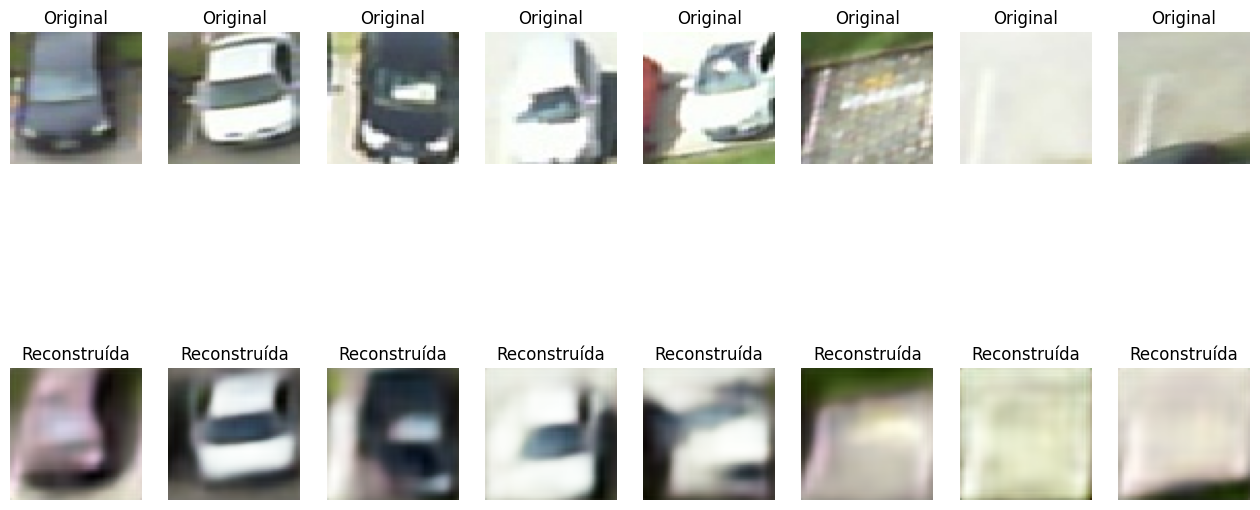

In [3]:
gerador = Gerador(min_layers=2, max_layers=6)
modelo = gerador.construir_modelo()
gerador.compilar_modelo()
gerador.Dataset("Datasets_csv/df_PUC.csv")
gerador.setNome("Teste")
gerador.treinar_autoencoder(epocas=10, salvar=True, batch_size=32) 

Pesos carregados com sucesso
Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/5


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 2 objects could not be loaded. Example error message for object <Dense name=dense_1, built=True>:

Layer 'dense_1' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense_1, built=True>, <Dense name=dense_2, built=True>]
  warnings.warn(msg)
/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9048 - loss: 0.2648 - val_accuracy: 0.9860 - val_loss: 0.0439
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
 17/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9812 - loss: 0.0648

2024-10-04 15:47:18.381515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:18.381547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-04 15:47:18.386910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:18.386937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9883 - loss: 0.0448 - val_accuracy: 0.9945 - val_loss: 0.0264
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
 17/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9954 - loss: 0.0207

2024-10-04 15:47:20.120993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:20.121026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030
2024-10-04 15:47:20.125392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12973647737495713219
2024-10-04 15:47:20.125419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16866395874398474030


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9925 - loss: 0.0296 - val_accuracy: 0.9945 - val_loss: 0.0255
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step
Número de amostras em y_true: 2000
Número de amostras em predicoes_classes: 2000


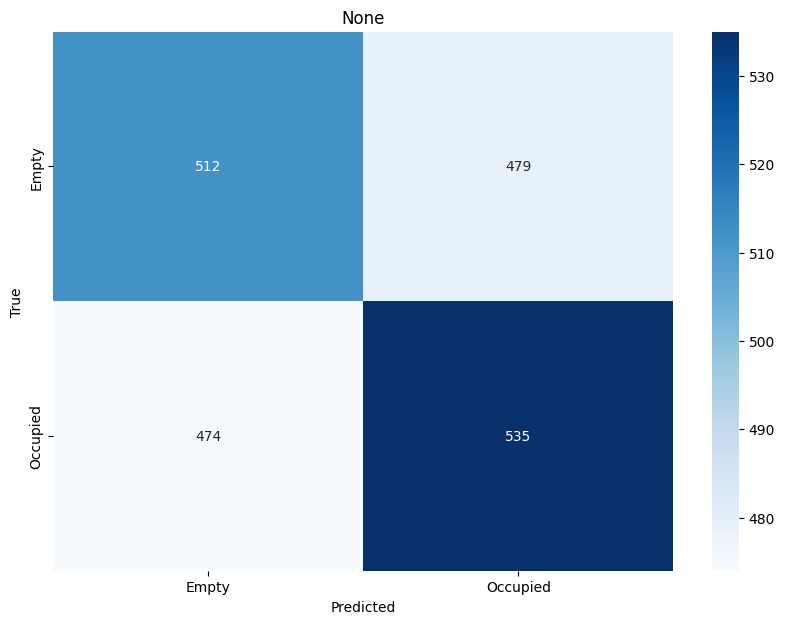

array([1, 0, 1, ..., 0, 1, 1])

In [4]:
from Preprocessamento import preprocessamento

classificadorPUC = GeradorClassificador(gerador.encoder, gerador.getPesos())
treinoPUC, validacaoPUC, testePUC, treino_dfPUC, validacao_dfPUC, teste_dfPUC = preprocessamento(input_shape = (64,64), caminho="Datasets_csv/df_PUC.csv", autoencoder=False)
classificadorPUC.Dataset('Datasets_csv/df_PUC.csv')
classificadorPUC.treinamento(epocas=5)
classificadorPUC.predicao()